In [ ]:
#!pip install tensorflow

In [ ]:
# DIGIT RECOGNIZER # код взят отсюда https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# 1 ВВЕДЕНИЕ

In [22]:
# импортируем зависимости
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2) # фиксируем random seed для повторяемости результатов

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. Data preparation

## 2.1 Load data

In [25]:
# Займёмся подготовкой данных
# для начала загрузим данные
train = pd.read_csv("/home/dmitry/digit-recognizer/train.csv")
test = pd.read_csv("/home/dmitry/digit-recognizer/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

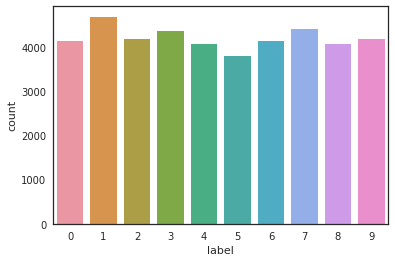

In [26]:
# Выведем график распределения изображений цифр по классам
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

## 2.2 Check for null and missing values

In [27]:
# Check the data
# Проверим данные на пропущенные и нулевые значения
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [28]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
# Пропущенных, поврежденных или нулевых данных нет, можем двигаться дальше


## 2.3 Normalization

In [31]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
# Нормализуем данные, чтобы пиксели принимали значения в диапазоне не [0,255], а [0,1]

## 2.4 Reshape

In [33]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
# Поменяем форму входных данных из одномерного вектора (784,) в трёхмерную матрицу (28, 28, 1)
# Если было бы RGB, изображение, то было бы три канала, например, (28, 28, 3)

## 2.5 Label encoding

In [34]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)
# Надо перекодировать классы в векторы для корректной работы сети, например, 2 -> [0,0,1,0,0,0,0,0,0,0])

## 2.6 Split training and valdiation set

In [36]:
# Set the random seed
random_seed = 2
# Зафиксируем random seed для повторяемости результатов

In [37]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
## Разделим train на обучающую выборку и валидационную выборку.Валидационная выборка служит для настройки 
# гиперпараметров нейронной сети в процессе обучения

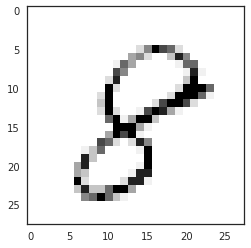

In [54]:
# Some examples
g = plt.imshow(X_train[0][:,:,0],cmap='Greys')

# 3. CNN

## 3.1 Define the model

In [41]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Функция активации - функция(например, softmax, relu), которая на основе входных данных нейрона определяет 
# выходное значение нейрона

# Модель последовательная. Мы добавляем слой за слоем к нашей сети.Так как сеть содержит не один слой, а несколько,
# то сеть называется глубокой. Сеть состоит из входного, выходного и скрытых слоёв. Входной слой имеет форму, 
# соответствующую форме изображения (28,28,1). Одним из трюков является распрямление картинки в одномерный вектор 
# на входном слое(если используются не сверточные сети, а например, простой многослойный персептрон, состоящий 
# из нескольких полносвязных слоёв). Свёрточные слои(Conv2D) используются для генерации признаков по изображению.
# Слои MaxPool2D используется для уменьшения размера картинки в 4 раза. Слои Dropout используются для борьбы с 
# переобучением путём удаления части связей между слоями (для того чтобы понять почему это работает, можно почитать 
# про байессовский вывод). Слои Flatten используются для распрямления и схлопывания картинки в вектор. 
# Слой Dense(полносвязный), в данном случае, используется в качестве выходного слоя для классификации на 10 классов. 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 3.2 Set the optimizer and annealer

In [43]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Оптимизатор - специальная штука, которая реализует алгоритм, позволяющий обновлять веса нейронной сети

In [44]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# метрика оценивает качество обучения нейронной сети
# метрика accuracy(доля правильных ответов) показывает сколько раз сеть правильно выбрала нужный класс 
# на всех тестовых примерах,
# то есть количество правильных ответов ко всем ответам на тестовой выборке
# Функция потерь - эта функция, которую мы оптимизируем(уменьшаем её значение) во время обучения, 
# на валидационной и обучающей выборке. Функция categorical_crossentropy позволяпет решать задачу 
# многоклассовой классификации

In [45]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# скорость обучения(learning rate) - гиперпараметр обучения нейронной сети. 
# При очень большом значении этого параметра, мы можем проскочит глобальный минимум функции оптимизации,
# при очень маленьком значении этого параметра очень долго обучаться.

In [48]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
# Настраиваем параметры обучения: количество эпох(сколько раз через сеть будет пропущена вся обучающая выборка) 
# и размер батча(сколько за раз кидаем изображений в сеть). Обучение состоит из нескольких эпох, 
# эпоха состоит из нескольких батчей,батч включает в себя несколько изображений.

## 3.3 Data augmentation

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)
# Аугментация данных используется для того чтобы сеть была устойчива к афинным преобразованиям изображений
# (поворотам, отражениям, растяжениям, сжатиям, увеличениям(зумам), вырезам и закрытиям части изображений и т.д.) 

In [46]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [49]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

# Обучим модель

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 264s - loss: 0.4203 - acc: 0.8659 - val_loss: 0.0847 - val_acc: 0.9755


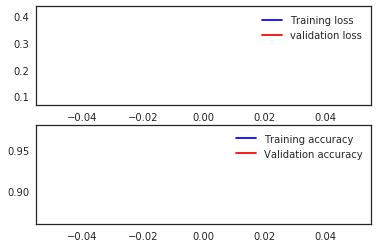

In [50]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
# Изображения пусты, так как мы обучались одну эпоху(несколько минут). 
# Если обучаться несколько эпох(например, 30 или 2 с половиной часа)
# то здесь будут зависимости функции потерь и метрики доля правилиных ответов на обучающей и
# валидационной выборки в зависимости от эпохи.
# По таким графикам, исследователи данных определяют, как прошло обучение нейронной сети, не произошло ли 
# недообучения или переобучения(overfitting) 

## 4.2 Confusion matrix

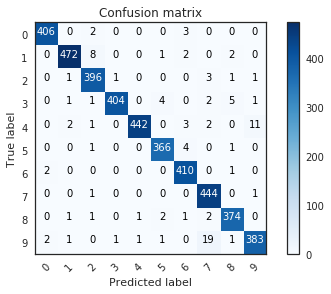

In [51]:
# Look at confusion matrix
# Нарисуем матрицу ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

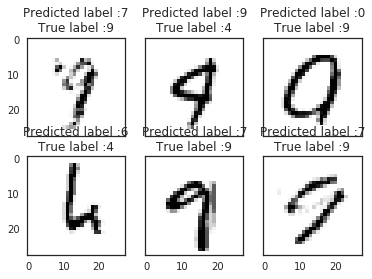

In [56]:
# Display some error results 
# Отобразим некоторые ошибки обученной сети

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap='Greys')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [53]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

# Предсказать значения при помощи обученной модели можем с помощью метода predict